In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from python_files.maxent import MaxEnt
import python_files.densities as d
from scipy.stats import kstest
import time

In [2]:
cwd = os.getcwd()
data = np.load(cwd+"/skewness_kurtosis/example_fields.npy")
print(data.shape) #19 images

(19, 256, 256)


Max: 27.32 || Min: -0.82
Avg: 1.4e-09 || Var: 1.0000
Skewness: 7.33 || Kurtosis: 100.98


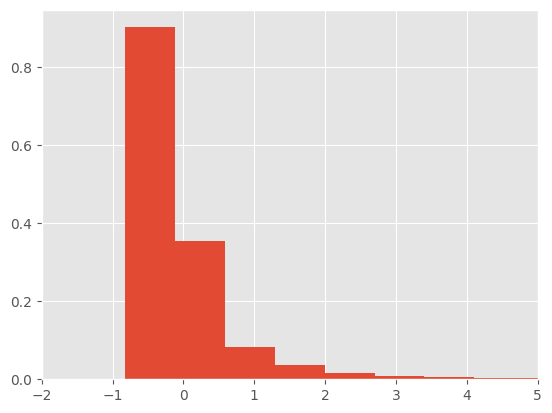

In [3]:
arr = data[2].flatten()
print(f"Max: {np.max(arr):.2f} || Min: {np.min(arr):.2f}")
print(f"Avg: {np.mean(arr):.1e} || Var: {np.var(arr):.4f}")
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")
plt.hist(arr, density=True, bins=40)
plt.xlim(-2,5)
plt.show()

The resulting parameters:
  Lambda_1 = -0.303
  Lambda_2 = -1.012
  Lambda_3 = 0.131
  Lambda_4 = -0.004


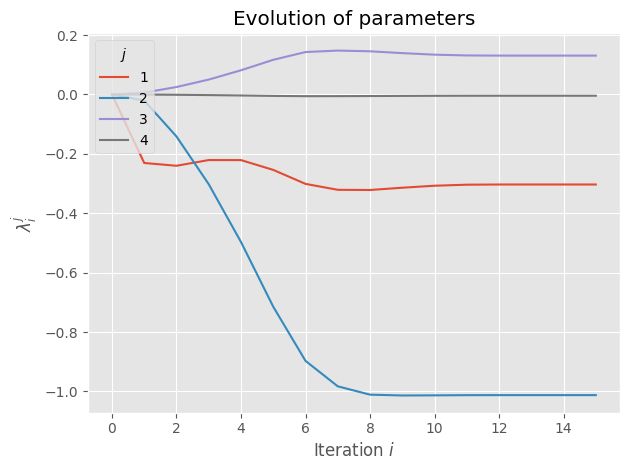

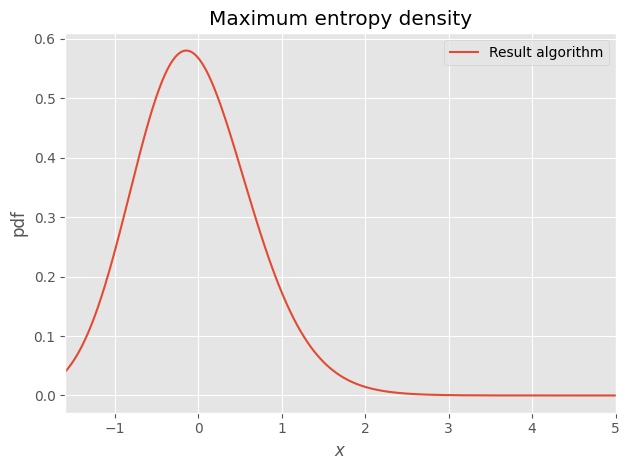

In [4]:
i = 0 #number of picture to look at
picture = data[i]
picture_flat = picture.flatten()
l = np.min(picture)
u = np.max(picture)+.1
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
n = 150

ob_skewkurt = MaxEnt(support=(l,u),
                     n_quadrature=n,
                     b_constraints=d.b_constraint_skewkurt(skew,kurt),
                     f_vector=d.f_constraint_skewkurt)
ob_skewkurt.visualize_algorithm()
ob_skewkurt.visualize_solution(xlim=(l,5))

0.9972440618906646


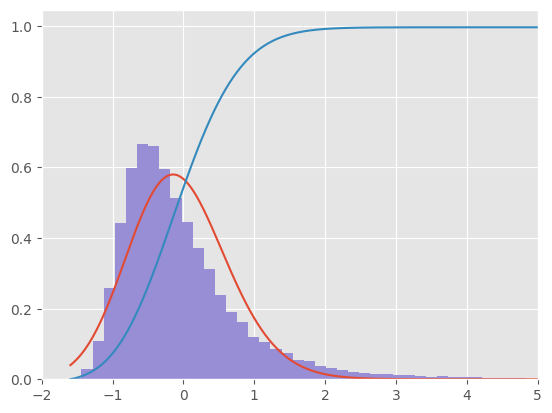

In [5]:
N=500
xx = np.linspace(l,5,N)

y = ob_skewkurt.pdf(xx)
yy = ob_skewkurt.cdf(xx)
print(yy[-1])
plt.plot(xx,y)
plt.plot(xx,yy)
plt.hist((data[i]).flatten(), density=True, bins=100)
plt.xlim(-2,5)
plt.show()


In [6]:
def batch_rejection_sample(density, xlim, C, N):
    Y = np.random.uniform(*xlim,size=N)
    U = np.random.uniform(size=N)
    mask = (U <= (xlim[1]-xlim[0])*density(Y)/C)
    return Y[mask]

def rejection_sampling(size, density, xlim, n_batch=5000):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""

    # Determine C s.t. density(x) <= C * (b-a)^-1
    N = 10000
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])
    
    results = np.array([])
    while(results.size<size):
        results = np.append(results, batch_rejection_sample(density,xlim,
                                                            C,N=1000))
    
    return results[:size]



In [7]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, 
                        i,
                        extra_upper_l=0.01, 
                        n=150, 
                        u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt,
                        k_max=200, 
                        message_norm=False)
    # ob_skewkurt.visualize_algorithm()
    # ob_skewkurt.visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)
    
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {i}")
    ax[0].grid()
    
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    res_sample = kstest(image_flat, sample_ME)
    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.savefig(f"skewness_kurtosis/generated_copy_example_{i}.pdf")
    plt.show()

    # res = kstest(image_flat, ob_skewkurt.cdf)
    # print(f"p-value of KS-test on cdf and real sample: {res.pvalue:.3e}")
    print(f"p-value of KS-test on simulated and real sample: {res_sample.pvalue:.3e}")

def generate_copy_image_6(image_raw, i,extra_upper_l=0.01, n=150, u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)
    m6 = np.mean(image_flat**6)
    m8 = np.mean(image_flat**8)
    m10 = np.mean(image_flat*10)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt_6(skew,
                                                                kurt,
                                                                m8),
                        f_vector=d.f_constraint_skewkurt_6)
    # ob_skewkurt.visualize_algorithm()
    ob_skewkurt.visualize_solution(xlim=(l,u_show))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {i}")
    ax[0].grid()
    
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    res_sample = kstest(image_flat, sample_ME)
    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # res = kstest(image_flat, ob_skewkurt.cdf)
    # print(f"p-value of KS-test on cdf and real sample: {res.pvalue:.3e}")
    print(f"p-value of KS-test on simulated and real sample: {res_sample.pvalue:.3e}")

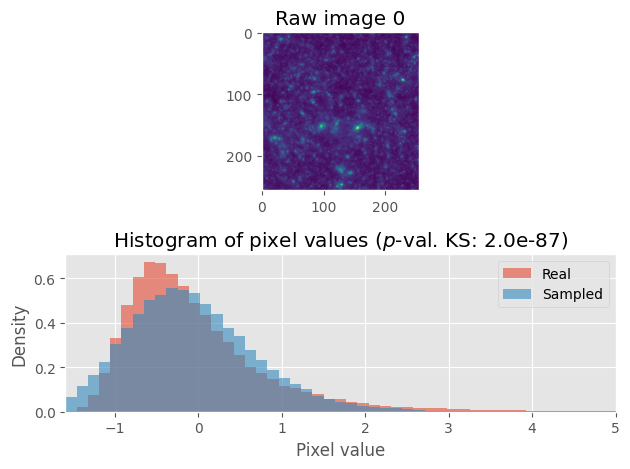

p-value of KS-test on simulated and real sample: 1.951e-87


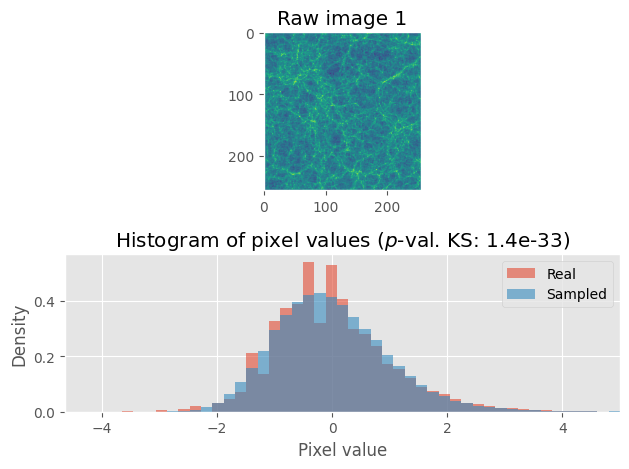

p-value of KS-test on simulated and real sample: 1.415e-33


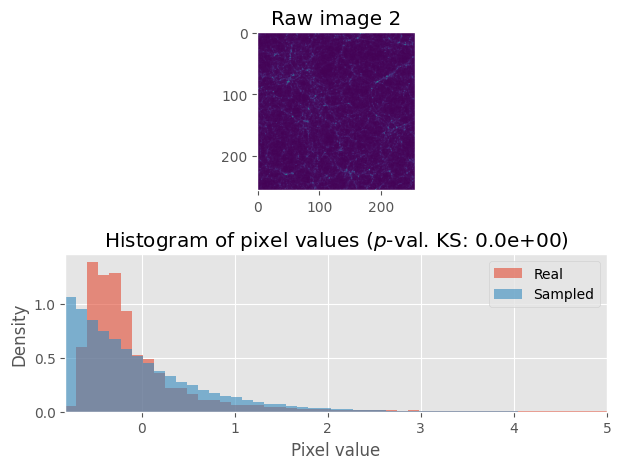

p-value of KS-test on simulated and real sample: 0.000e+00


In [15]:
for i in range(3):
    generate_copy_image(data[i],
                        i,
                        extra_upper_l=0, 
                        n=150,
                        u_show=5)
    # generate_copy_image_6(data[i],
    #                     i,
    #                     extra_upper_l=0, 
    #                     n=150,
    #                     u_show=5)

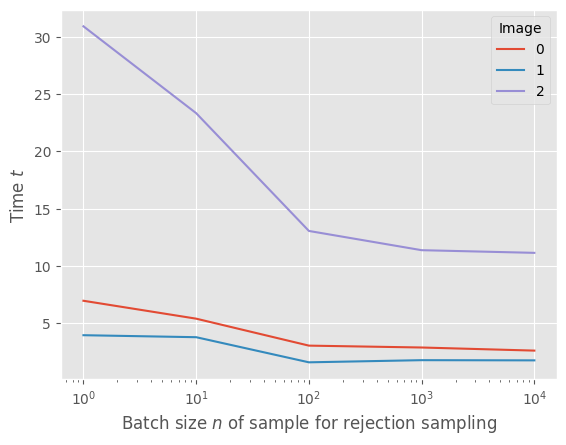

In [17]:
# This is the results of an experiment to determine a correct size for 
# rejection sampling: how many uniformly distributed samples generated at a time?
# This was done with first three images from example_fields.npy.
# Conclusion: 1000 seems plenty
n_batches = [1, 10, 100, 1000, 10000]
time_0 = [6.949514, 5.386701, 3.033129, 2.869381, 2.598656]
time_1 = [3.943141, 3.768776, 1.575756, 1.763992, 1.746679]
time_2 = [30.908321, 23.325781, 13.044381, 11.365089, 11.132723]
plt.plot(n_batches, np.array([time_0,time_1,time_2]).T,
         label=[i for i in range(3)])
plt.xscale("log")
plt.xlabel("Batch size $n$ of sample for rejection sampling")
plt.ylabel("Time $t$")
plt.legend(title="Image")
plt.show()

In [1]:
i = 0
generate_copy_image_6(data[i], 
                      i,
                    extra_upper_l=0.1, 
                    n=150,
                    u_show=10)

NameError: name 'generate_copy_image_6' is not defined